## C S 329E HW 6

# KNN 

## Your name here (and your partner's name if you are working in a pair)

Tori Garfield teg755
Veronica Alejandro vaa678

For this week's homework we are going explore one new classification technique:

  - k nearest neighbors

We are using a different version of the Melbourne housing data set, to predict the housing type as one of three possible categories:

  - 'h' house
  - 'u' duplex
  - 't' townhouse

At the end of this homework, I expect you to understand how to build and use a kNN model, and practice your data cleaning and data preparation skills. 

In [1]:
# These are the libraries you will use for this assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

# Starting off loading a training set
df_melb = pd.read_csv('melb_data_train.csv')

## Q1 - Fix a column of data to be numeric
If we inspect our dataframe, `df_melb` using the `dtypes` method, we see that the column "Date" is an object.  However, we think this column might contain useful information so we want to convert it to [seconds since epoch](https://en.wikipedia.org/wiki/Unix_time). Use only the exiting imported libraries to create a new column "unixtime". Be careful, the date strings in the file might have some non-uniform formatting that you have to fix first.  Print out the min and max epoch time to check your work.  Drop the original "Date" column. Please use the python [reference for time](https://docs.python.org/3/library/time.html) to help you do the string to Unix time conversion. 

In [2]:
# normalize date accepts the date string as shown in the df_melb 'Date' column,
# and returns a data in a standarized format
def standardize_date(d):
    # Your code here
    d = d.split('/')
    dNew = ''
    
    #day 
    if len(d[0]) != 2:
        dNew += '0'
    dNew += d[0] + '/'
    
    #month
    if len(d[1]) != 2:
        dNew += '0'
    dNew += d[1] + '/'
    
    #year
    if len(d[2]) != 4:
        dNew += '20'
    dNew += d[2]
    
    return dNew

In [3]:
df_melb['Date'] = df_melb['Date'].apply( lambda x : standardize_date(x)) 
df_melb['unixtime'] = pd.to_datetime(df_melb['Date'], format='%d/%m/%Y')
df_melb['unixtime'] = df_melb['unixtime'].apply(lambda x : int(x.timestamp()))
df_melb = df_melb.drop(columns="Date")

print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_melb['unixtime'].min(),df_melb['unixtime'].max()))

The min unixtime is 1454544000 and the max unixtime is 1506124800


## Q2 Use Imputation to fill in missing values
kNN doesn't work when the attributes are not valid for all of the attribute columns, so fill in all the missing values in `df_melb` with the mean of that column.  Save the mean of each column in a dictionary, `dict_imputation`, whose key is the attribute column name, so we can apply the same imputation to the test set later. Show your `dict_imputation` dictionary and the head of your `df_melb` dataframe.  The target classfication is stored in the column `'Type'`, so we are going to define a variable target_col so we can reference the target_col using a variable. (hint: during imputation you skip the target column)

In [4]:
target_col = 'Type'

In [5]:
dict_imputation = dict()
for col in df_melb.columns:
    # your code here
    if col != target_col: #skip target column
        mean = df_melb[col].mean() #calculate mean of the column
        dict_imputation[col] = mean #save mean of column to dict
        df_melb[col] = df_melb[col].fillna(value = mean) #fill in the missing values with mean

In [6]:
dict_imputation

{'Rooms': 2.710769230769231,
 'Price': 941972.2953846154,
 'Distance': 10.206256410256408,
 'Postcode': 3110.873846153846,
 'Bathroom': 1.4543589743589744,
 'Car': 1.4938398357289528,
 'Landsize': 514.2184615384615,
 'BuildingArea': 131.379476861167,
 'YearBuilt': 1971.0204429301534,
 'unixtime': 1485036288.0}

In [7]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,3,t,732000,5.6,3101,1,1.0,904,110.000000,1980.000000,1469491200
1,3,h,1001000,12.6,3020,1,5.0,879,131.379477,1971.020443,1488585600
2,2,u,605000,7.4,3185,1,1.0,722,131.379477,1970.000000,1462579200
3,3,h,757500,18.8,3170,2,1.0,145,131.379477,1971.020443,1497657600
4,4,h,721000,17.9,3082,2,2.0,603,131.379477,1971.020443,1505520000


## Q3 Normalize all the attributes to be between [0,1]
Normalize all the attribute columns in `df_melb` so they have a value between zero and one (inclusive). Save the (min,max) tuple used to normalize to a dictionary, `dict_normalize`, so we can apply it to the test set later.  The dataframe `df_melb` is now your "model" that you can use to classify new data points. (hint: during normalization you skip the target column)

In [8]:
dict_normalize = dict()
for col in df_melb.columns:
    # your code here
    if col != target_col : #skip target column
        colMin = df_melb[col].min() #calculate min
        colMax = df_melb[col].max() #calculate max
        tup = (colMin, colMax) #make a tuple
        
        dict_normalize[col] = tup #save tuple to dict
        df_melb[col] = (df_melb[col] - colMin) / (colMax - colMin)

In [9]:
dict_normalize

{'Rooms': (1, 7),
 'Price': (210000, 5020000),
 'Distance': (0.7, 47.3),
 'Postcode': (3000, 3810),
 'Bathroom': (0, 5),
 'Car': (0.0, 8.0),
 'Landsize': (0, 41400),
 'BuildingArea': (0.0, 3558.0),
 'YearBuilt': (1850.0, 2016.0),
 'unixtime': (1454544000, 1506124800)}

In [10]:
df_melb.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.333333,t,0.108524,0.105150,0.124691,0.2,0.125,0.021836,0.030916,0.783133,0.289782
1,0.333333,h,0.164449,0.255365,0.024691,0.2,0.625,0.021232,0.036925,0.729039,0.659966
2,0.166667,u,0.082121,0.143777,0.228395,0.2,0.125,0.017440,0.036925,0.722892,0.155779
3,0.333333,h,0.113825,0.388412,0.209877,0.4,0.125,0.003502,0.036925,0.729039,0.835846
4,0.500000,h,0.106237,0.369099,0.101235,0.4,0.250,0.014565,0.036925,0.729039,0.988275


## Q4 Load in the Test data and prep it for classification
Everything we did to our "train" set, we need to now do in our "test" set. 

In [11]:
df_test = pd.read_csv("melb_data_test.csv")

In [12]:
# Your code here to fix date
df_test['Date'] = df_test['Date'].apply(lambda x : standardize_date(x))
df_test['unixtime'] = pd.to_datetime(df_test['Date'], format='%d/%m/%Y')

df_test['unixtime'] = df_test['unixtime'].apply(lambda x : int(x.timestamp()))
df_test = df_test.drop(columns="Date")

print("The min unixtime is {:d} and the max unixtime is {:d}".format(df_test['unixtime'].min(),df_test['unixtime'].max()))

The min unixtime is 1454544000 and the max unixtime is 1506124800


In [13]:
# Your code here for imputation - must use dictionary from above!
for col in df_test.columns:
    if col != target_col:
        df_test[col] = df_test[col].fillna(value = dict_imputation[col])
df_test.head()        

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,2,t,790000,11.2,3046,2,1.0,208,127.000000,2010.000000,1497657600
1,3,h,1355000,8.8,3072,1,2.0,916,131.379477,1971.020443,1476489600
2,5,h,2810000,6.3,3143,2,2.0,617,131.379477,1971.020443,1472342400
3,3,h,850000,10.5,3034,1,1.0,593,118.000000,1970.000000,1472860800
4,3,h,810000,38.0,3199,1,2.0,835,118.000000,1960.000000,1499472000


In [14]:
# Your code here for scaling - must use dictionary from above!
for col in df_test.columns:
    if col != target_col:
        colMin = dict_normalize[col][0]
        colMax = dict_normalize[col][1]
        df_test[col] = (df_test[col] - colMin) / (colMax - colMin)
df_test.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,unixtime
0,0.166667,t,0.120582,0.225322,0.056790,0.4,0.125,0.005024,0.035694,0.963855,0.835846
1,0.333333,h,0.238046,0.173820,0.088889,0.2,0.250,0.022126,0.036925,0.729039,0.425461
2,0.666667,h,0.540541,0.120172,0.176543,0.4,0.250,0.014903,0.036925,0.729039,0.345059
3,0.333333,h,0.133056,0.210300,0.041975,0.2,0.125,0.014324,0.033165,0.722892,0.355109
4,0.333333,h,0.124740,0.800429,0.245679,0.2,0.250,0.020169,0.033165,0.662651,0.871022


## Q5 Write the kNN classifier function
Your function `knn_class`, should take four parameters, the training dataframe (that includes the target column), the hyper parameter `k`, the name of the target column, and a single observation row (a series generated from iterrows) of the test dataframe.  We are assuming that the parameter `df_train` contains all of the attributes, and the target class in the same dataframe. The function returns the predicted target classification for that observation. To find the distance between the single observation and the training data frame you may use the [L2 norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

In [15]:
def knn_class(df_train, k, target_col, observation ):
   # your code here
    df_train['distance'] = df_train.apply(lambda x : np.linalg.norm(x.drop(index=target_col) - observation), axis=1)
    df_train = df_train.sort_values(by='distance').reset_index(drop=True)
    df_k = df_train[0:k]
    return df_k[target_col].value_counts().index[0]

## Q6 Compute the accuracy using different k values
For each value of $k$ in the set $\{1,3,13,25,50,100\}$ calculate the class prediction for each oberservation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$.

Which value of $k$ would you chose?

Note, this took 5 minutes on my computer. 

In [16]:
poss_k = [1,3,13,25,50,100] # possible k's
acc_k = [0,0,0,0,0,0] # the accuracy at each value of k

# Your code here
acc_indx = 0
for k in poss_k :
    predictions = df_test.apply(lambda x : knn_class(df_melb, k, target_col, x.drop(index=target_col)), axis=1)
    
    correct = np.sum(predictions == df_test[target_col])
    acc_k [acc_indx] = correct / len(predictions)
    
    print("k = ", k, "Acc = ", acc_k[acc_indx])
    acc_indx = acc_indx + 1


k =  1 Acc =  0.10655737704918032
k =  3 Acc =  0.6967213114754098
k =  13 Acc =  0.6967213114754098
k =  25 Acc =  0.6967213114754098
k =  50 Acc =  0.19672131147540983
k =  100 Acc =  0.19672131147540983


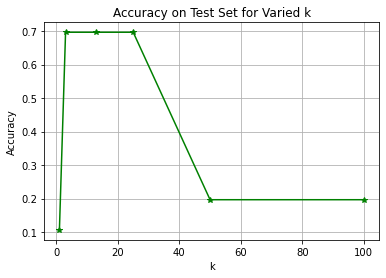

In [17]:
# plot code here
plt.plot(poss_k, acc_k, 'g-*')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy on Test Set for Varied k')
plt.grid('on')
plt.show()

I would choose $k = 3 $, $ k = 13 $, or $ k = 25 $ because it yields the highest accuracy values, both at about 69.7%. 